# Business Understanding

Dengan semakin banyaknya konten yang tersedia di platform streaming film, pengguna dihadapkan pada pilihan yang sangat beragam. Tanpa bantuan sistem yang tepat, pengguna mungkin kesulitan menemukan konten yang sesuai dengan preferensi mereka, yang dapat berdampak pada pengalaman pengguna (user experience) dan keterlibatan mereka dengan platform. Dari sudut pandang bisnis, menampilkan konten yang relevan secara konsisten dapat meningkatkan waktu tayang pengguna (watch time), retensi pelanggan, dan pada akhirnya meningkatkan pendapatan melalui langganan yang lebih lama atau konsumsi konten berbayar yang lebih banyak.

**Problem Statements**
- Bagaimana solusi bagi pengguna agar tidak kesulitan dalam menemukan konten film sesuai dengan preferensi mereka pada platform streaming?  
- Bagaimana memberikan suatu pertimbangan bagi pengguna untuk bertahan dalam menggunakan platform streaming?

**Goals**
- Mengembangkan sistem rekomendasi film berbasis content-based filtering.
- Memberikan output top-N rekomendasi film yang mirip dengan film yang dipilih pengguna.

**Solution statements**
- Menggunakan pendekatan **Content-Based Filtering**, hal ini dilakukan dengan memanfaatkan deskripsi film, genre, keywords, aktor, dan sutradara sebagai fitur konten. Kemiripan antar film akan diukur menggunakan algoritma Term Frequency-Inverse Document Frequency (TF-IDF) dan Cosine Similarity

# Data Understanding

Dataset yang digunakan merupakan dataset yang berisikan informasi detail mengenai berbagai film, termasuk judul, tanggal rilis, genre, sinopsis, aktor, sutradara, rating, dan lain-lain. Dataset ini diperoleh dari Kaggle: [TMDB 5000 Movie Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading

In [2]:
df_movies = pd.read_csv("/content/tmdb_5000_movies.csv")
df_credits = pd.read_csv("/content/tmdb_5000_credits.csv")

## Exploratory Data Analysis

Dalam Exploratory Data Analysis (EDA) ini akan dilakukan dua tahap analisis, yaitu:
- Univariate Analysis (menganalisis masing-masing informasi dari dataset)
- Multivariate Analysis (menganalisis dua atau lebih informasi dari dataset)

### Univariate Analysis

1. Movies Dataset

In [3]:
# Menampilkan dataset movies
df_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [5]:
print("Banyak judul film:", len(df_movies.title.unique()))

Banyak judul film: 4800


Movie Dataset (4803 x 20):
- Terdapat missing value pada kolom `homepage`, `overview`, `release_date`, `runtime`, `tagline`
- Memiliki kombinasi tipe data yaitu int64, object, float64

Banyaknya judul film pada dataset berjumlah 4800 film, hal ini menandakan adanya indikasi duplikasi data atau missing value, sebab maksimal baris data pada kolom "title" berjumlah 4803 judul

Text(0.5, 1.0, 'Distribusi Vote Average')

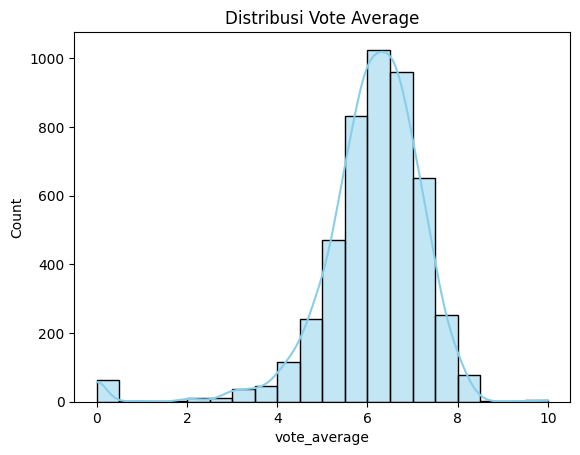

In [6]:
# Distribusi Vote Average
sns.histplot(df_movies['vote_average'], bins=20, kde=True, color='skyblue')
plt.title("Distribusi Vote Average")

Mayoritas film memiliki skor rata-rata (vote_average) antara 6 hingga 7, yang menunjukkan bahwa sebagian besar film dalam dataset ini memperoleh penilaian yang cukup baik dari penonton, meskipun tidak terlalu ekstrem. Sehingga film-film di dalam dataset ini kredibel

Distribusi rating ini juga menyerupai distribusi normal, mengindikasikan tidak adanya bias besar terhadap rating sangat rendah atau sangat tinggi.

Text(0.5, 1.0, 'Distribusi Runtime Film')

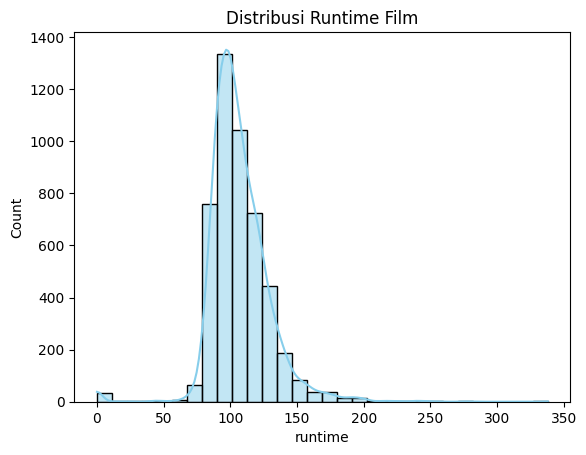

In [7]:
# Distribusi runtime film
sns.histplot(df_movies['runtime'].dropna(), bins=30, kde=True, color='skyblue')
plt.title("Distribusi Runtime Film")

Kebanyakan film berdurasi antara 90 hingga 120 menit, yang merupakan standar industri perfilman untuk film layar lebar. Namun, terdapat distribusi yang sedikit condong ke kanan (positively skewed), mengindikasikan adanya sejumlah kecil film berdurasi sangat panjang. Hal ini berkemungkinan target produksi film memang menyajikan film dengan durasi yang panjang

2. Credits Dataset

In [8]:
# Menampilkan dataset credits
df_credits

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [9]:
df_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


Dari analisis di atas terdapat 4 kolom fitur dan 4803 baris pada dataset credits

### Multivariate Analysis

Text(0.5, 1.0, 'Korelasi Budget vs Revenue')

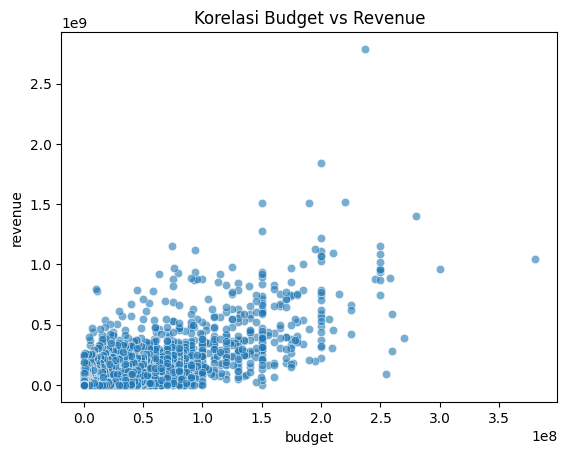

In [10]:
# Melihat korelasi revenue vs budget
sns.scatterplot(data=df_movies, x='budget', y='revenue', alpha=0.6)
plt.title("Korelasi Budget vs Revenue")

Terdapat hubungan positif antara besarnya anggaran produksi film dengan pendapatan yang dihasilkan. Secara umum, film dengan anggaran lebih tinggi cenderung memiliki potensi meraih pendapatan lebih besar.

Namun, hubungan ini tidak bersifat linier, karena terdapat banyak penyimpangan di mana film dengan budget tinggi tidak selalu menghasilkan revenue tinggi. Sebaliknya, beberapa film berbudget rendah juga mampu menghasilkan pendapatan yang cukup besar, menunjukkan bahwa faktor kesuksesan film tidak hanya ditentukan oleh besarnya anggaran.

<Axes: xlabel='revenue', ylabel='title'>

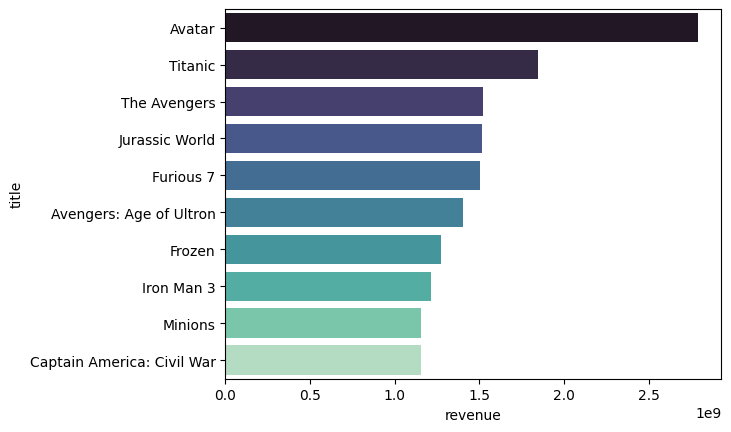

In [11]:
# Melihat top 10 film dengan revenue tertinggi
top_revenue = df_movies[['title', 'revenue']].sort_values(by='revenue', ascending=False).head(10)
sns.barplot(data=top_revenue, y='title', x='revenue', palette='mako')

Film dengan revenue terbanyak yaitu Avatar, diikuti dengan Titanic dan The Avengers

# Data Preparation

Melakukan delapan tahap persiapan data, yaitu:
1. Rename Column
2. Drop Column
3. Merge Dataset
4. Selection Feature
5. Handling Missing Value dan Duplicate Data
6. Mengekstrak, Menggabungkan, dan Memberi Bobot List pada Isi Fitur
7. Normalisasi Teks (Cleaning Text) pada Isi Fitur
8. Vectorization TF-IDF

1. Rename Column

In [12]:
# Mengubah nama kolom "movie_id" pada dataset credits menjadi "id"
df_credits = df_credits.rename(columns={"movie_id": "id"})
df_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4803 non-null   int64 
 1   title   4803 non-null   object
 2   cast    4803 non-null   object
 3   crew    4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


Hal ini bertujuan untuk menyelaraskan nama kolom id pada kedua dataset sebelum melakukan penggabungan (merge) dataset

2. Drop Column

In [13]:
# Menghapus kolom title di dataset credits
df_credits = df_credits.drop(columns=['title'])

Melakukan drop (hapus) kolom "title" pada salah satu dataset untuk melakukan proses penggabungan agar kolom tidak double.

3. Merge Dataset

In [14]:
# Menggabungkan dataset movies dan credits
df_merge = df_movies.merge(df_credits, on="id", how="left")
df_merge.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [15]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

Menggabungkan kedua dataset menjadi dataset gabungan. Sebab kita membutuhkan beberapa fitur yang ada pada dataset credits, sehingga perlu dilakukan penggabungan (merge). Menghasilkan 22 kolom fitur pada dataset baru

4. Feature Selection

In [16]:
# Seleksi fitur yang akan digunakan
df = df_merge[["id", "title", "genres", "keywords", "overview", "cast", "crew"]]
df.head(1)

,id,title,genres,keywords,overview,cast,crew
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


Membuat dataset baru, dengan memilih fitur yang dibutuhkan saja. Kolom `id`, `title`, `genres`, `keywords`, `overview`, `cast`, dan `crew` dianggap penting sebab dapat merepresentasikan sebuah film

5. Handling Missing Value dan Duplicate Data

In [17]:
df.isnull().sum()

,0
id,0
title,0
genres,0
keywords,0
overview,3
cast,0
crew,0


In [18]:
df.dropna(inplace=True)
df.shape

(4800, 7)

In [19]:
print("Jumlah duplikasi data: ", df.duplicated().sum())

Jumlah duplikasi data:  0


Terindikasi 3 missing value pada overview. Sebab gambaran umum dari film tidak kita ketahui, lebih baik baris missing value di hapus. Sehingga dataset terdiri dari 4800 baris dan 7 kolom penting

6. Mengekstrak, Menggabungkan, dan Memberi Bobot List pada Isi Fitur

In [20]:
# Ekstrasi fitur
def extract_list(text):
    try:
        data = json.loads(text)
        return [item['name'] for item in data]
    except:
        return []

df['genres'] = df['genres'].apply(extract_list)
df['keywords'] = df['keywords'].apply(extract_list)
df['cast'] = df['cast'].apply(lambda x: extract_list(x)[:3]) # Ambil 3 aktor pertama
df['crew'] = df['crew'].apply(lambda x: [item['name'] for item in json.loads(x) if item['job'] == 'Director'][0] if any(item['job'] == 'Director' for item in json.loads(x)) else '')

df.head(1)

,id,title,genres,keywords,overview,cast,crew
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron


 Beberapa kolom seperti genres, keywords, cast, dan crew berisi data dalam format JSON. Perlu dilakukan ekstraksi untuk mendapatkan daftar genre, kata kunci, nama aktor, dan nama sutradara.

In [21]:
# Penggabungan Fitur Teks
def combine_features(row):
    overview = row['overview'].split() if isinstance(row['overview'], str) else []
    return ' '.join(overview + row['genres'] + row['keywords']*2 + row['cast']*3 + [row['crew']]*2)

df["tags"] = df.apply(combine_features, axis=1)

In [22]:
df.head(1)

,id,title,genres,keywords,overview,cast,crew,tags
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"In the 22nd century, a paraplegic Marine is di..."


Menggabungkan teks dari kolom overview, daftar genre, keywords, nama aktor, dan nama sutradara menjadi satu representasi teks (kolom "tags") untuk setiap film. Ini akan menjadi input utama untuk perhitungan kemiripan konten. Selain itu memberikan pembobotan pada fitur yang dianggap berpengaruh seperti fitur keywords, cast, dan crew

In [23]:
df_final = df[["id", "title", "tags"]]
df_final.head(1)

,id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."


Membuat dataset final yang terdiri dari id film, judul film, dan representasi film (tags)

7. Normalisasi Teks List (Cleaning Text)

In [24]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # Mengubah teks menjadi huruf kecil
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Hilangkan karakter selain huruf dan spasi
    tokens = word_tokenize(text) # Tokenisasi (memecah kalimat jadi kata-kata)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Hilangkan stopwords & lemmatize
    return ' '.join(tokens) # Gabungkan kembali jadi string

df_final['tags'].apply(clean_text)

,tags
0,nd century paraplegic marine dispatched moon p...
1,captain barbossa long believed dead come back ...
2,cryptic message bond past sends trail uncover ...
3,following death district attorney harvey dent ...
4,john carter warweary former military captain w...
...,...
4798,el mariachi want play guitar carry family trad...
4799,newlywed couple honeymoon upended arrival resp...
4800,signed sealed delivered introduces dedicated q...
4801,ambitious new york attorney sam sent shanghai ...


In [25]:
df_final['tags'] = df_final['tags'].apply(clean_text)
df_final.head()

,id,title,tags
0,19995,Avatar,nd century paraplegic marine dispatched moon p...
1,285,Pirates of the Caribbean: At World's End,captain barbossa long believed dead come back ...
2,206647,Spectre,cryptic message bond past sends trail uncover ...
3,49026,The Dark Knight Rises,following death district attorney harvey dent ...
4,49529,John Carter,john carter warweary former military captain w...


Melakukan pembersihan (normalisasi) teks pada kolom "tags" sebelum masuk ke tahap modeling. Hal ini dilakukan agar model dapat mengolah representasi film untuk memperoleh hasil konten yang serupa
- Lowercase: Mengubah teks menjadi huruf kecil
- Re.sub: Menghilangkan karakter yang bukan spasi dan huruf
- Tokenisasi: Memecah teks menjadi unit-unit kata (token)
- Stopword Removal: Menghapus kata-kata umum dalam bahasa inggris yang tidak memiliki banyak informasi semantik
- Lemmatization: Mengembalikan kata-kata ke dalam bentuk dasarnya, misalnya stories menjadi story

8. Vectorization TF-IDF

In [26]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df_final['tags'])

Dilakukan terhadap fitur gabungan (overview, genres, keywords, cast, dan crew) yang telah digabung ke dalam kolom "tags" untuk mengubahnya menjadi vektor numerik agar dapat mengukur pentingnya sebuah kata dalam sebuah dokumen relatif terhadap kumpulan dokumen lainnya.

# Model Development & Result

## Modeling

Pada tahap ini, pengembangan model dilakukan dengan:
- Menghitung cosine similarity antara vektor TF-IDF dari fitur yang telah divektorkan terhadap film. Cosine similarity mengukur sudut antara dua vektor, dengan nilai 1 menunjukkan kemiripan sempurna dan nilai 0 menunjukkan tidak ada kemiripan
- Memberikan rekomendasi untuk film tertentu, sistem akan mencari film-film lain dengan nilai cosine similarity tertinggi terhadap film tersebut.

In [27]:
# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [28]:
# Membuat reverse mapping dari indeks ke judul film
indices = pd.Series(df_final.index, index=df_final['title']).drop_duplicates()

In [29]:
# Fungsi untuk Mendapatkan Rekomendasi dengan Skor Cosine Similarity
def get_recommendations_with_scores(title, cosine_sim=cosine_sim, df=df_final, indices=indices):
    try:
        idx = indices[title]
    except KeyError:
        print(f"Film '{title}' tidak ditemukan dalam dataset.")
        return []

    # Dapatkan skor similaritas untuk film tersebut dengan semua film lain
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Urutkan film berdasarkan skor similaritas
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Dapatkan skor untuk 5 film yang paling mirip (tidak termasuk film itu sendiri)
    sim_scores = sim_scores[1:6]

    # Dapatkan indeks film dan skor similaritas
    movie_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]

    # Kembalikan DataFrame yang berisi judul dan skor similaritas
    df_recommendations = pd.DataFrame({'title': df_final['title'].iloc[movie_indices], 'similarity_score': similarity_scores})
    return df_recommendations

## Results

In [30]:
# Contoh penggunaan sistem rekomendasi 1 (satu) dengan skor
movie_title = "Iron Man"
recommendations_with_scores = get_recommendations_with_scores(movie_title)

print(f"\nRekomendasi film untuk '{movie_title}' dengan perhitungan Cosine Similarity:")
print(recommendations_with_scores)


Rekomendasi film untuk 'Iron Man' dengan perhitungan Cosine Similarity:
                         title  similarity_score
79                  Iron Man 2          0.638752
31                  Iron Man 3          0.586217
7      Avengers: Age of Ultron          0.518114
16                The Avengers          0.492665
26  Captain America: Civil War          0.482212


In [31]:
# Contoh penggunaan sistem rekomendasi 2 (dua) dengan skor
movie_title = "The Fast and the Furious"
recommendations_with_scores = get_recommendations_with_scores(movie_title)

print(f"\nRekomendasi film untuk '{movie_title}' dengan Cosine Similarity:")
print(recommendations_with_scores)


Rekomendasi film untuk 'The Fast and the Furious' dengan Cosine Similarity:
                 title  similarity_score
44           Furious 7          0.514879
500   2 Fast 2 Furious          0.437285
204          Fast Five          0.428334
1083      Babylon A.D.          0.315712
568                xXx          0.314293


# Evaluasi

#### **Metode Evaluasi**

Evaluasi ini berbasis relevansi rekomendasi yaitu Precision, dengan formula sebagai berikut\
`Precision = Jumlah rekomendasi film yang relevan / Jumlah item film yang direkomendasikan`
  
**Evaluasi penggunaan sistem rekomendasi 1 (satu):**\
**Film yang dipilih: Iron Man**
- Precision = 5/5
- Hasil Presisi Sistem Rekomendasi Film untuk Iron Man = 100%
- **Alasan Relevansi:**
  - Iron Man 2 → Sangat relevan (sekuel langsung)
  - Iron Man 3 → Sangat relevan (sekuel langsung)
  - Avengers: Age of Ultron → Relevan (Iron Man sangat berperan di film ini)
  - The Avengers → Relevan (Iron Man juga karakter utama)
  - Captain America: Civil War → Relevan (Iron Man juga memiliki peran utama di sini)

**Evaluasi penggunaan sistem rekomendasi 2 (dua)**\
**Film yang dipilih: The Fast and the Furious**
- Precision = 3/5
- Hasil Presisi Sistem Rekomendasi Film untuk The Fast and the Furious = 60%
- **Alasan Relevansi:**
  - Furious 7 → Relevan (satu franchise Fast and Furious)
  - 2 Fast 2 Furious → Relevan (sekuel Fast and Furious)
  - Fast Five → Relevan (seri kelima Fast and Furious)
  - Babylon A.D. → Kurang relevan (film aksi fiksi ilmiah, memang dibintangi Vin Diesel, tapi bukan bagian dari Fast and Furious)
  - xXx → Kurang relevan (juga film aksi Vin Diesel, tapi beda universe, bukan Fast and Furious)

Dengan menggunakan pendekatan Content-Based Filtering menggunakan TF-IDF dan Cosine Similarity dalam membangun sistem rekomendasi, diharapkan model ini dapat membantu memberikan dampak signifikan terhadap pemahaman bisnis dan potensi pertumbuhan platform streaming film.
